<center><font size=6><b>GEOS 669 Geodetic Methods and Modeling</b></font></center>

# Lab 7: Modeling - Time Series Fitting


### Introduction

Today, I will give you synthetic 3 component data and you will invert for parameters of several linear models that we expect in the time series data.

### NOTE
Since we're doing this in Python, the numpy functions [hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) and [vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html) will come in quite handy.

### Say "Hi" to FICT
FICT is a fictitious GPS site near some plate interface. Its long term trend looks like travel to the SSE and during its time it experienced an earthquake on day 413, which set it back to the NNW. We're getting quite some seasonal action, too. See what the time series looks like in 3 components below.

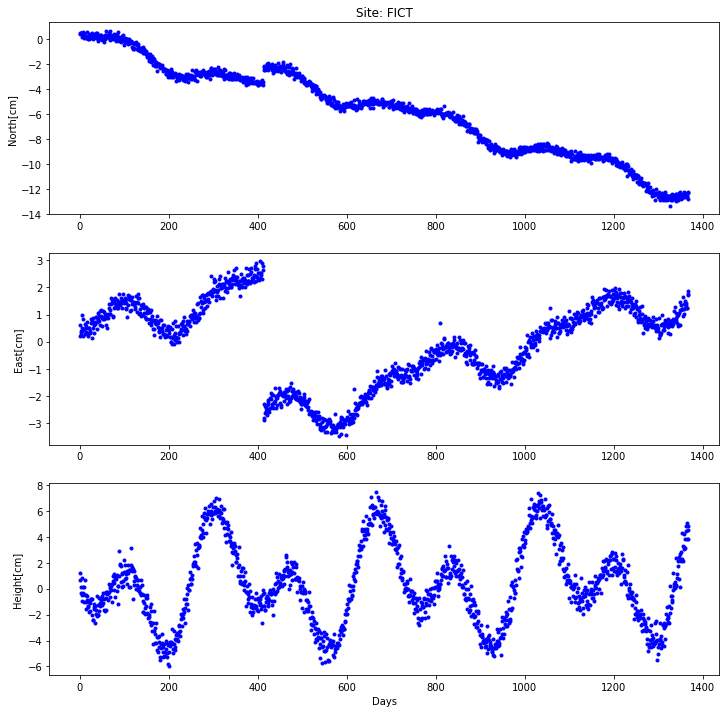

In [1]:
from IPython import display
display.Image("fict.png")

In [2]:
#We're again making sure that all the output is displayed 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scipy.io

#loads dN, dE, dU
fict = scipy.io.loadmat('FICT.mat')

#imports necessary for further work
import numpy as np
import matplotlib.pyplot as plt

dE = fict['dE']
dN = fict['dN']
dU = fict['dU']

total_days = len(dE)

#make a column vector for time
t  = np.array(range(total_days)).reshape(total_days, 1)

In [3]:
#add your plotting code below to this cell

### Background
I created these time series using a model that is a scaled superposition of:

- y-offset
- gradient (velocity)
- annual sine and cosine
- semiannual sine and cosine
- heaviside function with offset at day 413.

The parameters for the sines, cosines and heaviside function you are looking for are the scaling factors. The periodicity is defined by annual ($\frac{2\pi}{365}$) and semiannual ($\frac{4\pi}{365}$). As heaviside step function use this vector:

`h_vec = np.vstack( [np.zeros((413,1)), np.ones((total_days-413,1))])`
	
where `total_days` is the length of the timeseries in one component provided above. This gives you a function that is zero until day 413 and one after day 413.

We use the same model (equation) for all three components, but as you can see in the time series, the coefficient values will come out differently. This is easily justified: the same physics affect one site, but they act differently on it depending on the direction.

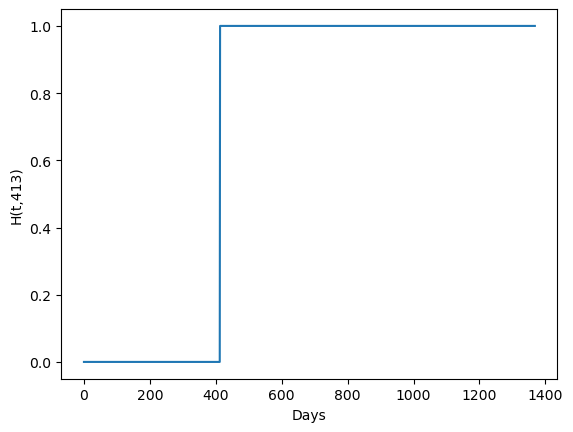

In [5]:
#create a heaviside like function for our problem
h_vec = np.vstack( [np.zeros((413,1)), np.ones((total_days-413,1))])

plt.plot(t, h_vec)
plt.xlabel('Days')
plt.ylabel('H(t,413)');


Your next task: Write the model equation for 1 component. The equation should contain 7 coefficients. **DO NOT SKIP THIS STEP!**

**Write your equation here:**



### The Fitting - Part 1

You now have an understanding of the model and you are aware that you need to find 7 model parameters for each component. How to go about this? Yes, let's try least-squares!

Recall that:

`d = G * m`
    
At this stage you can make a huge mistake: trying to solve the problem for all components at once. **Do NOT do this! (Some of you will, despite this being in bold and the "not" in all-caps. Those who tried in the past ended in trouble. Maybe you'll be brave and learn from history?)** 

How about we try to figure out the fit for the North component first and then we expand in the other directions? And even better - let's start with fewer model components!

To begin with: Your data `d` will be `dN` as it is in the `mat` file (loaded into `fict`, so `fict[dN]`. The model parameters `m` are what you need to determine. `G` will have to contain model-parameter many columns, and data-point many rows. 

Begin by setting up `G` for a linear fit first:

`d = a + b*t` 
	

For the linear problem, how many columns has `G`? \
What are the values in the columns?

**Answer the questions here:**


Now solve the inverse problem:

$m = G^{-1} d$
	
The most straightforward way to solve the inverse problem using least squares in Python is with numpy's [lstsq function](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html):

``` 
    m = np.linalg.lstsq(G, d, rcond=None)[0]
```

Your model vector `m` will contain 2 parameters, `a_m`, `b_m`. Plot the north component and your model below.

In [6]:
#solve the line-fitting problem here and plot:

What are the values and units of `a`, `b`? \
What is the velocity (`b`) in cm/year?

**Add your response here:**

Once you've got `G` set up for two of your model components, the expansion to include the 5 others should be straightforward: add the scaling factors to `m` and the (unit) functions (i.e., unscaled functions) as columns into `G`. Their order won't matter, as long as you keep the order of the respective scaling factors the same. Plot the model over the time series. You get that by solving the forward model, i.e., the equation you've written out at the beginning.

In [8]:
#add your code to estimate all 7 parameters for one component here.

### The Fitting - Part 2

You are 2 critical steps away from being able to fit all three time series using 1 least squares inversion. Even though I am not giving any covariances here to properly weight the data, recall that the full least-squares solution is:

`m = (G'WG)^(-1) * G'Wd`
	
Where `W` could be a diagonal matrix with the reciprocals of the covariances on the diagonal. Once you think about covariances you should realize that you'd need to invert for all parameters that characterize the time series in your three components at the same time.

With that in the back of your minds you want to set up 1 data vector and 1 design matrix to get 1 model vector. The trick is to think in subsets! Create 1 long column vector containing all your data. The first third will be, maybe, the north component; the middle third will be the east component and the last third could be the vertical component.

This idea maps directly into your result / model vector: The first 7 components will be the ones describing the north time series, the middle 7 components will describe the east time series, and the last 7 components will characterize the vertical.

Understanding and doing this, was the first critical step. The second step involves the proper expansion of your design matrix `G`. You will need to add blocks of zeros so that you end up with something like this:
```
         [ GN  0  0 ]
     G = [  0 GE  0 ]
         [  0  0 GU ]
```
	
where `GN` is exactly the design matrix you created in section 3. In fact, `GN == GE == GU`! And each zero represents a matrix of size of `GN` filled with zeros (think a bit how this is easiest achieved without writing too much code).

In [10]:
#Add your solution code here


### Some final Questions

In your answers, please give reasonable levels of precision that are justified by the level of precision achievable with GNSS. Just because Python gives you nano-meter precision doesn't mean GNSS actually has it.

- What is the static offset at day 413 in all 3 components? How does this compare to the "plate motion" or long term velocity?
- What are amplitude and azimuth (degrees from north) of the horizontal motion for this event?
- What is the annual sine and cosine amplitude in the vertical component?
- Is this overall a convincing time series, or do you see any issues?

**Answer the questions above here in full sentences**
